# BTC to USD - From EDA to Machine Learning

### Reading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv',index_col="Date",parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3027 entries, 2014-09-17 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3027 non-null   float64
 1   High       3027 non-null   float64
 2   Low        3027 non-null   float64
 3   Close      3027 non-null   float64
 4   Adj Close  3027 non-null   float64
 5   Volume     3027 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 165.5 KB


- The data has no missing values. 3027 values starting from september 2014 until now.
- Open, High and Close values are features provided by the data from the YahooFinance website
- Those 3 variables provided in the dataset are decimal values (float64) format.
- The volume variable is an integer (int64)

## Descriptive Statistics 

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3.027000e+03
mean,12857.132760,13181.429151,12494.089969,12860.960943,12860.960943,1.634552e+10
std,16192.848432,16607.230962,15713.089474,16187.886656,16187.886656,1.997810e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,672.772003,684.252991,663.082001,674.816498,674.816498,1.006360e+08
50%,7092.291504,7280.521973,6890.540039,7096.279785,7096.279785,7.364150e+09
75%,16809.051758,17090.261719,16534.487305,16808.360352,16808.360352,2.793474e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


- The average close value is USD 12860.96 with a standard deviation of USD16187.88
- 75% of the close value is around 16808.36 and 25% around 674.81

<Figure size 720x720 with 0 Axes>

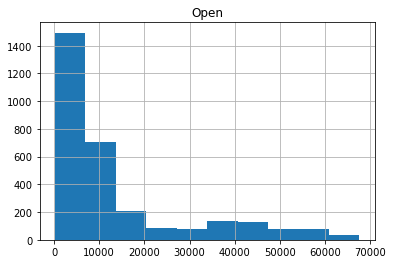

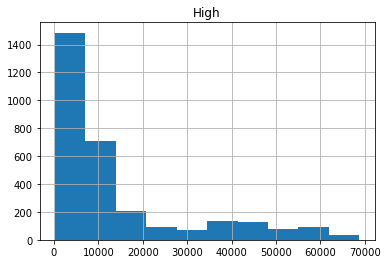

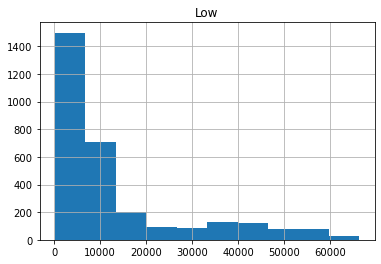

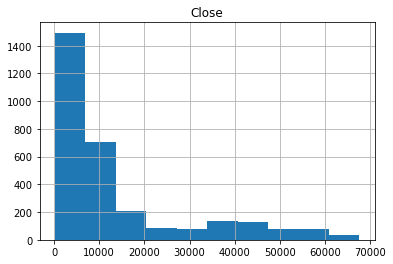

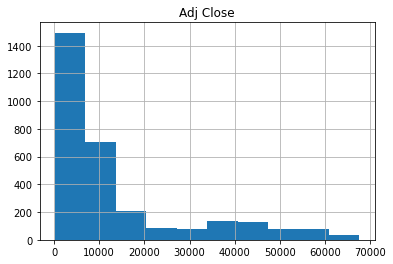

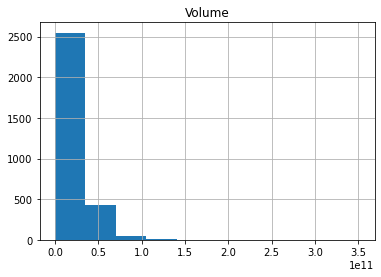

In [5]:
plt.figure(figsize=(10,10))
for c in list(df.columns):
    df[[c]].hist()

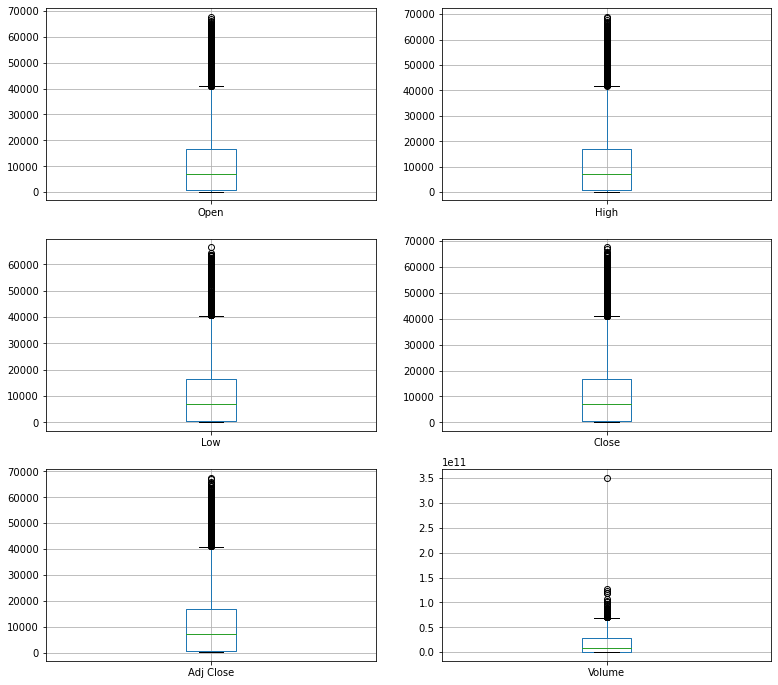

In [6]:
plt.figure(figsize=(13,12))
j=1
for c in list(df.columns):
    plt.subplot(3,2,j)
    df[[c]].boxplot()
    j=j+1

We are dealing with so many outliers from the data. A special data scaling will be used when building machine learning models.

# Time Series Exploratory Data Analysis

In [7]:
price = df['Close'].copy()

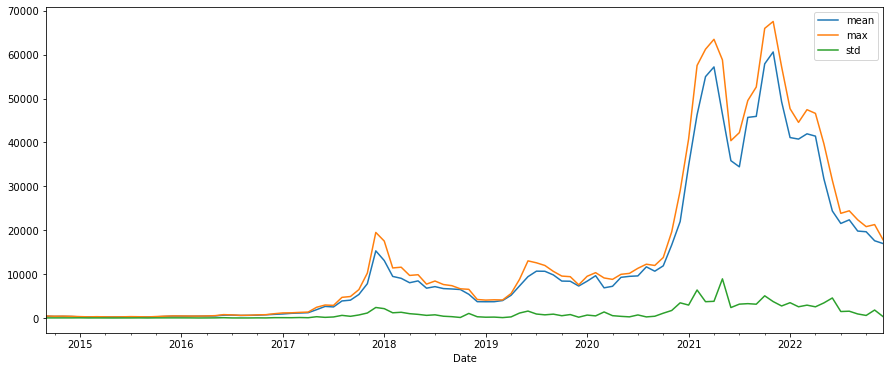

In [8]:
plt.figure(figsize=(15,6))
price.resample('m').mean().plot(label='mean')
price.resample('m').max().plot(label='max')
price.resample('m').std().plot(label='std')
plt.legend()

Since 2023, BitCoin was volatile. It has: 
- 4 peaks
- one in 2018
- 2 peaks in 2021
- 1 in 2022.

### Plotting the moving average

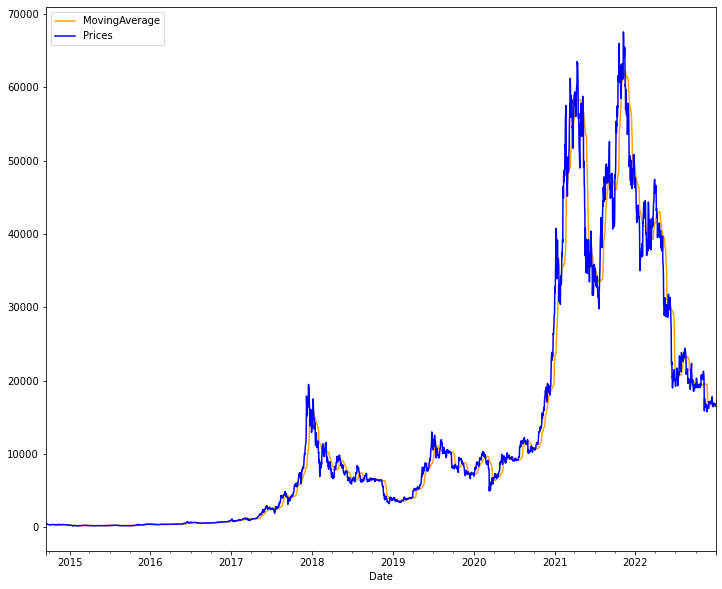

In [9]:
plt.figure(figsize=(12,10))
price.rolling(window=30).median().plot(label='MovingAverage',color='Orange')
price.plot(color='blue',label='Prices')
plt.legend()

The orange line is the average value of bitcoin through each months

# Model Building Part

In [10]:
from sklearn.model_selection import train_test_split
price_train,price_test=train_test_split(df['Close'],shuffle=False,test_size=0.2)

In [11]:
from value_processing import create_windowed_values
X_train,Y_train = create_windowed_values(price_train)
X_test,Y_test = create_windowed_values(price_test)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA

In [13]:
pca =make_pipeline(MinMaxScaler(),PCA(n_components=8))

In [14]:
sgd = make_pipeline(pca,RobustScaler(),SGDRegressor(warm_start=True,max_iter=200))
sgd.fit(X_train,Y_train)
sgd.score(X_test,Y_test)

0.9817514710623275

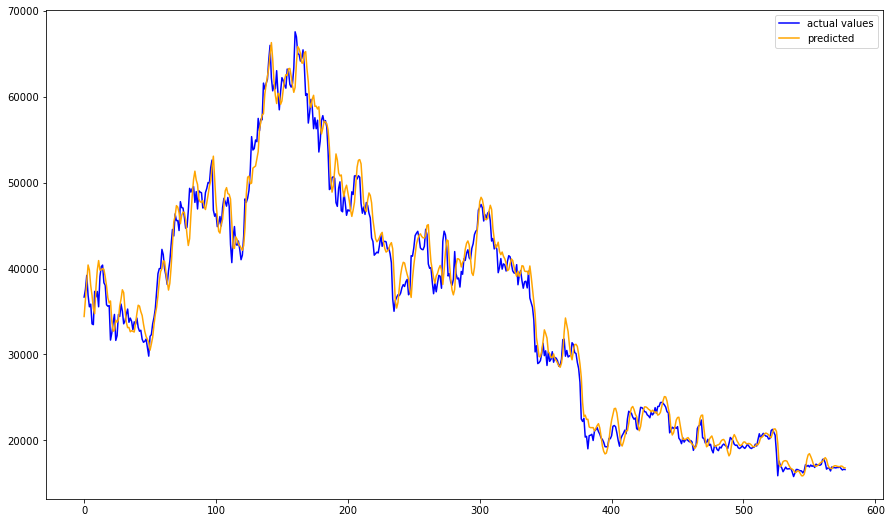

In [15]:
plt.figure(figsize=(15,9))
plt.plot(Y_test,label='actual values',color='blue')
plt.plot(sgd.predict(X_test),label='predicted',color='orange')
plt.legend()

# Error Analysis

In [16]:
ae = np.abs((Y_test-sgd.predict(X_test)))
sqe = (Y_test-sgd.predict(X_test))**2

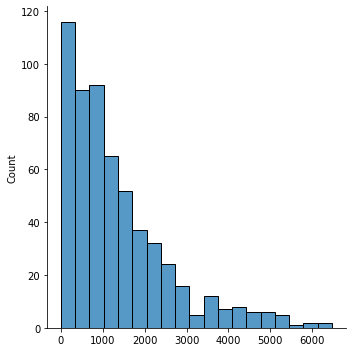

In [17]:
sns.displot(data=ae)

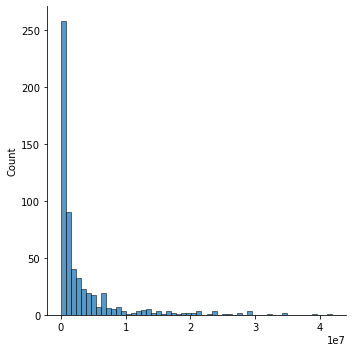

In [18]:
sns.displot(data=sqe)

It is better to estimate statistically the error as an interval. Let us use the scipy library for estimating a confidence interval

In [19]:
from scipy import stats
# Assuming you have an array of prediction errors called 'errors'
# Set the desired confidence level
def error_confidence_intervall(errors):
    confidence_level = 0.95  # Change as desired
    # Calculate the sample size
    n = len(errors)
    # Calculate the mean and standard deviation of the errors
    mean_error = np.mean(errors)
    std_error = np.std(errors, ddof=1)  # ddof=1 for unbiased estimation

    # Calculate the standard error of the mean
    std_error_mean = std_error / np.sqrt(n)

    # Calculate the degrees of freedom
    df = n - 1

    # Calculate the t-value based on the confidence level and degrees of freedom
    t_value = stats.t.ppf((1 + confidence_level) / 2, df)

    # Calculate the margin of error
    margin_of_error = t_value * std_error_mean

    # Calculate the confidence interval
    lower_bound = mean_error - margin_of_error
    upper_bound = mean_error + margin_of_error

    print(f"Confidence interval ({confidence_level * 100}%):")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")


In [22]:
error_confidence_intervall(sqe)

Confidence interval (95.0%):
Lower bound: 2861839.6393627212
Upper bound: 3849952.3167417604


In [25]:
error_confidence_intervall(ae)

Confidence interval (95.0%):
Lower bound: 1249.6135210868442
Upper bound: 1451.9739060376255


In [24]:
from save_load_model import save_model
file_name = "btc_pred.p"
save_model({"model":sgd},file_name)

--ML Model saved--
